In [3]:
# import h2o lib and allow it to use max. threads
library(h2o)
h2o.init(nthreads = -1)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T//Rtmpq7bB3D/h2o_phall_started_from_r.out
    /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T//Rtmpq7bB3D/h2o_phall_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 254 milliseconds 
    H2O cluster version:        3.14.0.3 
    H2O cluster version age:    21 days, 22 hours and 7 minutes  
    H2O cluster name:           H2O_started_from_R_phall_hxk658 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.56 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBo

In [4]:
# location of clean data file
path <- "/Users/phall/Documents/aetna/share/data/loan.csv"

In [5]:
# import file
frame <- h2o.importFile(path)

# strings automatically parsed as enums (categorical)
# numbers automatically parsed as numeric
# bad_loan is numeric, but categorical
frame$bad_loan <- as.factor(frame$bad_loan)

  |======================================================================| 100%


In [6]:
# summarize table
# decision tree ensembles can run on missing values
h2o.describe(frame)

Label,Type,Missing,Zeros,PosInf,NegInf,Min,Max,Mean,Sigma,Cardinality
loan_amnt,int,0,0,0,0,500.00,35000.00,1.307417e+04,7.993556e+03,NA
term,enum,0,129950,0,0,0.00,1.00,2.075591e-01,4.055605e-01,2
int_rate,real,0,0,0,0,5.42,26.06,1.371590e+01,4.391940e+00,NA
emp_length,int,5804,14248,0,0,0.00,10.00,5.684353e+00,3.610664e+00,NA
home_ownership,enum,0,1,0,0,0.00,5.00,NA,NA,6
annual_inc,real,4,0,0,0,1896.00,7141778.00,7.191567e+04,5.907092e+04,NA
purpose,enum,0,2842,0,0,0.00,13.00,NA,NA,14
addr_state,enum,0,413,0,0,0.00,49.00,NA,NA,50
dti,real,0,270,0,0,0.00,39.99,1.588153e+01,7.587668e+00,NA
delinq_2yrs,int,29,139459,0,0,0.00,29.00,2.273570e-01,6.941679e-01,NA


In [7]:
# assign target and inputs
y <- 'bad_loan'
X <- names(frame)[names(frame) != y]
print(y)
print(X)

[1] "bad_loan"
 [1] "loan_amnt"             "term"                  "int_rate"             
 [4] "emp_length"            "home_ownership"        "annual_inc"           
 [7] "purpose"               "addr_state"            "dti"                  
[10] "delinq_2yrs"           "revol_util"            "total_acc"            
[13] "longest_credit_length" "verification_status"  


In [8]:
# split into training and valid
split <- h2o.splitFrame(frame, ratios = 0.7)
train <- split[[1]]
valid <- split[[2]]

In [9]:
# random forest
# random forest is often the best guess model with little tuning

# train
loan_rf <- h2o.randomForest(
    x = X,
    y = y,
    training_frame = train,
    validation_frame = valid,
    ntrees = 500,                      # Up to 500 decision trees in the forest 
    max_depth = 30,                    # trees can grow to depth of 30
    stopping_rounds = 2,               # stop after validation error does not decrease for 5 iterations/new trees
    score_each_iteration = TRUE,       # score validation error on every iteration/new tree
    model_id = "loan_rf")              # for easy lookup in flow

# print model information
loan_rf

# view detailed results at http://ip:port/flow/index.html

  |======================================================================| 100%


Model Details:

H2OBinomialModel: drf
Model ID:  loan_rf 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              71                       71            14482305        30
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        30   30.00000      14318      15766 15016.56300


H2OBinomialMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.1428457
RMSE:  0.3779493
LogLoss:  0.5559982
Mean Per-Class Error:  0.3762284
AUC:  0.6702853
Gini:  0.3405706

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           0     1    Error           Rate
0      64999 28847 0.307387   =28847/93846
1       9326 11628 0.445070    =9326/20954
Totals 74325 40475 0.332517  =38173/114800

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.224146 0.378583 234
2     

In [10]:
# GBM with random hyperparameter search
# GBM often more accurate than random forest but requires some tuning

# define random grid search parameters
ntrees_opts = seq(100, 500, 50)
max_depth_opts = seq(2, 20, 2)
sample_rate_opts = seq(0.1, 0.9, 0.1)
col_sample_rate_opts = seq(0.1, 0.9, 0.1)

hyper_params = list(ntrees = ntrees_opts,
                    max_depth = max_depth_opts,
                    sample_rate = sample_rate_opts,
                    col_sample_rate = col_sample_rate_opts)

# search a random subset of these hyper-parmameters
# max runtime and max models are enforced
# and the search will stop after not improving much over the best 5 random models
search_criteria = list(strategy = "RandomDiscrete", 
                       max_runtime_secs = 300, 
                       max_models = 10, 
                       stopping_metric = "AUC", 
                       stopping_tolerance = 0.0001, 
                       stopping_rounds = 5, 
                       seed = 12345)

# execute training w/ grid search
loan_gbm <- h2o.grid("xgboost", 
                     grid_id = "gbm_grid",
                     x = X, 
                     y = y, 
                     training_frame = train,
                     validation_frame = valid,
                     
                     # per model stopping criteria 
                     stopping_rounds = 2,
                     stopping_tolerance = 1e-3,
                     stopping_metric = "AUC",
                     
                     # how often to score (affects early stopping, training speed)
                     score_tree_interval = 5, 
                     
                     # seed to control sampling 
                     seed = 12345,
                     # grid serach options
                     hyper_params = hyper_params,
                     search_criteria = search_criteria)

# view detailed results at http://ip:port/flow/index.html

  |======================================================================| 100%


In [11]:
# show grid results
sorted_grid <- h2o.getGrid(grid_id = "gbm_grid")
print(sorted_grid)

H2O Grid Details

Grid ID: gbm_grid 
Used hyper parameters: 
  -  col_sample_rate 
  -  max_depth 
  -  ntrees 
  -  sample_rate 
Number of models: 10 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
   col_sample_rate max_depth ntrees sample_rate        model_ids
1              0.3         2    100         0.8 gbm_grid_model_1
2              0.1         6    400         0.9 gbm_grid_model_0
3              0.1         6    200         0.8 gbm_grid_model_9
4              0.1        16    150         0.2 gbm_grid_model_5
5              0.6        12    150         0.4 gbm_grid_model_4
6              0.1        18    500         0.1 gbm_grid_model_3
7              0.3        18    250         0.8 gbm_grid_model_2
8              0.2        14    150         0.1 gbm_grid_model_8
9              0.9        20    400         0.5 gbm_grid_model_6
10             0.4        20    200         0.3 gbm_grid_model_7
               logloss
1   0.4368267182502

In [12]:
# select best model
best_model <- h2o.getModel(sorted_grid@model_ids[[1]])
summary(best_model)

Model Details:

H2OBinomialModel: xgboost
Model Key:  gbm_grid_model_1 
Model Summary: 
  number_of_trees
1              60

H2OBinomialMetrics: xgboost
** Reported on training data. **
** Metrics reported on training frame **

MSE:  0.1364647
RMSE:  0.3694113
LogLoss:  0.4331851
Mean Per-Class Error:  0.3504504
AUC:  0.7081903
Gini:  0.4163807

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           0     1    Error           Rate
0      64969 28877 0.307706   =28877/93846
1       8239 12715 0.393195    =8239/20954
Totals 73208 41592 0.323310  =37116/114800

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.202588 0.406581 204
2                       max f2  0.114648 0.565999 299
3                 max f0point5  0.296344 0.373832 127
4                 max accuracy  0.477996 0.818720  35
5                max precision  0.647816 0.687500   3
6         

In [13]:
# use variable importance to get insight into important relationships
h2o.varimp(best_model)

variable,relative_importance,scaled_importance,percentage
loan_amnt,25,1.00,0.138888889
annual_inc,24,0.96,0.133333333
int_rate,24,0.96,0.133333333
purpose,18,0.72,0.100000000
dti,17,0.68,0.094444444
term,16,0.64,0.088888889
total_acc,11,0.44,0.061111111
revol_util,10,0.40,0.055555556
addr_state,9,0.36,0.050000000
longest_credit_length,9,0.36,0.050000000


  |======================================================================| 100%


int_rate,mean_response,stddev_response
5.420000,0.07015702,0.03511409
6.506316,0.07015702,0.03511409
7.592632,0.08544631,0.03883005
8.678947,0.10023367,0.04406538
9.765263,0.12288495,0.05409519
10.851579,0.13366848,0.05786457
11.937895,0.14675322,0.06020822
13.024211,0.15229210,0.05868834
14.110526,0.17491073,0.06517546
15.196842,0.20645464,0.07397249


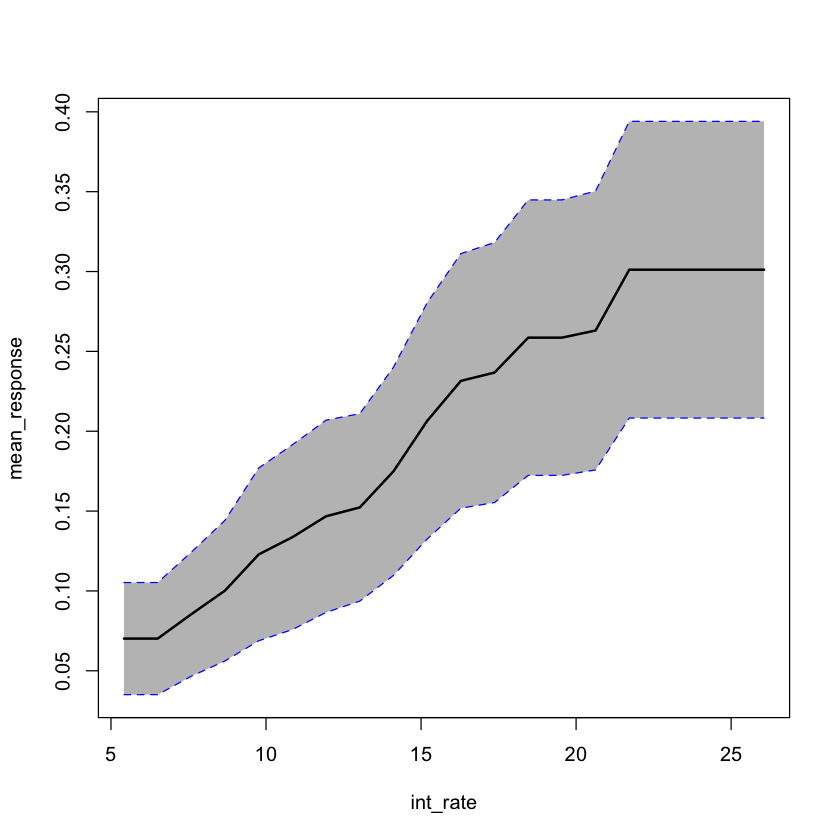

In [14]:
# use partial dependence plots to get insight into important relationships
h2o.partialPlot(best_model, valid, "int_rate")

In [15]:
h2o.shutdown(prompt = FALSE)

[1] TRUE